Answers to the Relax data science challenge. Please look at the Accompanying pdf for more information. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

/home/kirt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Load up the dataset and preview the dataframes to get a feel for the data

In [2]:
user_engagement_df = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])
users_df = pd.read_csv('takehome_users.csv', encoding = "ISO-8859-1", parse_dates=['creation_time'])

In [3]:
user_engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null datetime64[ns]
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


In [4]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB


The user engagement timestamp data looks clean. The user data is missing some values though. last_session_creation_time has some null values, which may signify an account that has never logged onto the system. This may be useful since we can assume if an account has never logged in, it has never adopted the platform. Missing values for invited_by_user_id probably signifies an account that did not receive an invitation. 

In [5]:
user_engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


First, identify adopted users using the timestamp dataset. Then combine it with the user dataset.

In [7]:
#Since multipule logins in a single day don't matter, 
#rework user engagement to only have date timestamps then remove duplicates. 
user_engagement_df['time_stamp'] = user_engagement_df['time_stamp'].dt.floor('d').astype(np.int64)
user_engagement_df = user_engagement_df.sort_values(['user_id', 'time_stamp']).drop_duplicates()

#To find three logins within a single week, we group up sorted timestamps with user_ids, 
#then create a rolling window that will do a calculation for every three time stamps. 
a = user_engagement_df.groupby('user_id')['time_stamp'].rolling(window=3)
#The calculation is to grab the time delta between the min and max dates of the window. 
b = pd.to_timedelta((a.max() - a.min())).dt.days
#If the time delta is seven days or less, we know the user is 'adopted.'
c = b[b <= 7].index.get_level_values('user_id').unique().tolist()

In [8]:
print("Total number of users: " + str(len(users_df)))
print("Number of adopted users: " + str(len(c)))
print("Adoption rate: " + str(len(c) / len(users_df)))

Total number of users: 12000
Number of adopted users: 1656
Adoption rate: 0.138


We now see that there is an adoption rate of about 14%. To better understand which features predict future user adoption we can make a basic DecisionTreeClassifier. Not only does the decision tree implictly perform feature selection, but its easier to interpret since we can visualize the decisions the model have made. Before we fit the model, we start some feature engineering. 

In [9]:
#Combine adopted users with user dataframe
users_df['adopted'] = 0
users_df.loc[users_df['object_id'].isin(c), 'adopted'] = 1

Earlier we noticed some missing values in last_session_creation_time and invited_by_user_id. For last_session_creation_time we assumed that the account was never created, and thus never adopted. Lets confirm. 

In [10]:
users_df[users_df['last_session_creation_time'].isnull()].adopted.value_counts()

0    3177
Name: adopted, dtype: int64

We could try to take this a step further and try to get the activity age of the account by subtracting creation_time from last_session_creation_time. Values of 0 here would possibly mean no adoption as well. 

In [11]:
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], unit='s')
users_df['age'] = users_df['last_session_creation_time'] - users_df['creation_time']
users_df['age'] = users_df['age'].dt.total_seconds()
users_df['age'].fillna(0, inplace=True)
users_df[users_df['age'] == 0].adopted.value_counts()

0    6204
Name: adopted, dtype: int64

This has identified even more inactive accounts. 

In [12]:
#Now one hot encode the creation_source feature
users_df = pd.concat([users_df, pd.get_dummies(users_df['creation_source'])], axis=1)
users_df.drop(['creation_source'], axis=1, inplace=True)

In [13]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 16 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null datetime64[ns]
name                          12000 non-null object
email                         12000 non-null object
last_session_creation_time    8823 non-null datetime64[ns]
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
adopted                       12000 non-null int64
age                           12000 non-null float64
GUEST_INVITE                  12000 non-null uint8
ORG_INVITE                    12000 non-null uint8
PERSONAL_PROJECTS             12000 non-null uint8
SIGNUP                        12000 non-null uint8
SIGNUP_GOOGLE_AUTH            12000 non-null uint8
dtypes: datetime64[ns](2), float64(2), int64(5), obje

In [14]:
#Drop irrelevant identifier columns and correct datatypes. 
users_df.drop(['name', 'email', 'object_id', 'creation_time', 'last_session_creation_time'], axis=1, inplace=True)
users_df['invited_by_user_id'].fillna(0, inplace=True)
convert_dict = {'invited_by_user_id': int,
                'age': int,
}
users_df = users_df.astype(convert_dict)

In [15]:
users_df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,age,GUEST_INVITE,ORG_INVITE,PERSONAL_PROJECTS,SIGNUP,SIGNUP_GOOGLE_AUTH
0,1,0,11,10803,0,0,1,0,0,0,0
1,0,0,1,316,1,11750400,0,1,0,0,0
2,0,0,94,1525,0,0,0,1,0,0,0
3,0,0,1,5151,0,86400,1,0,0,0,0
4,0,0,193,5240,0,432000,1,0,0,0,0


In [16]:
#Now we can train the decision tree model. Picking a lower max_depth for improved interpretability
X = users_df.drop('adopted', axis=1)
y = users_df.adopted
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
model = DecisionTreeClassifier(max_depth=4)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3407
           1       0.95      0.86      0.91       553

    accuracy                           0.98      3960
   macro avg       0.97      0.93      0.95      3960
weighted avg       0.97      0.98      0.97      3960



Those appear to be very good initial results. hyperparameter tuning and  more advanced models. Since the goal is the best understand the features, lets look into how the decision tree came up with these results. 

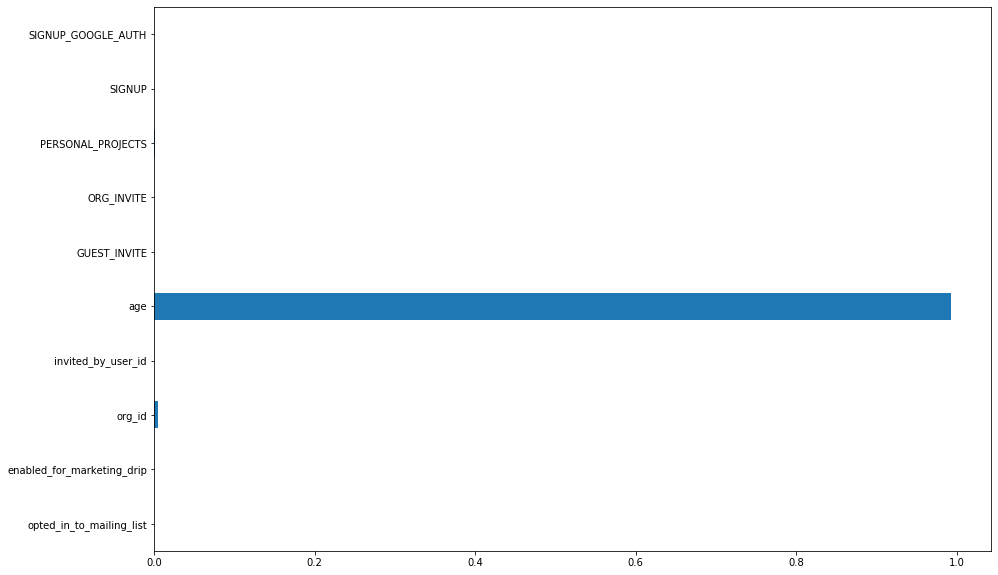

In [17]:
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.plot(kind='barh', figsize=(15,10))
pyplot.show()

It seems that the time between account creation and last login almost completely determines if a user will be adopted or not. There also seems to be a small weight given towards the organization the user was invited from. Possibly from a mandatory requirement within an organization. We can now visualizie the decision tree itself. 

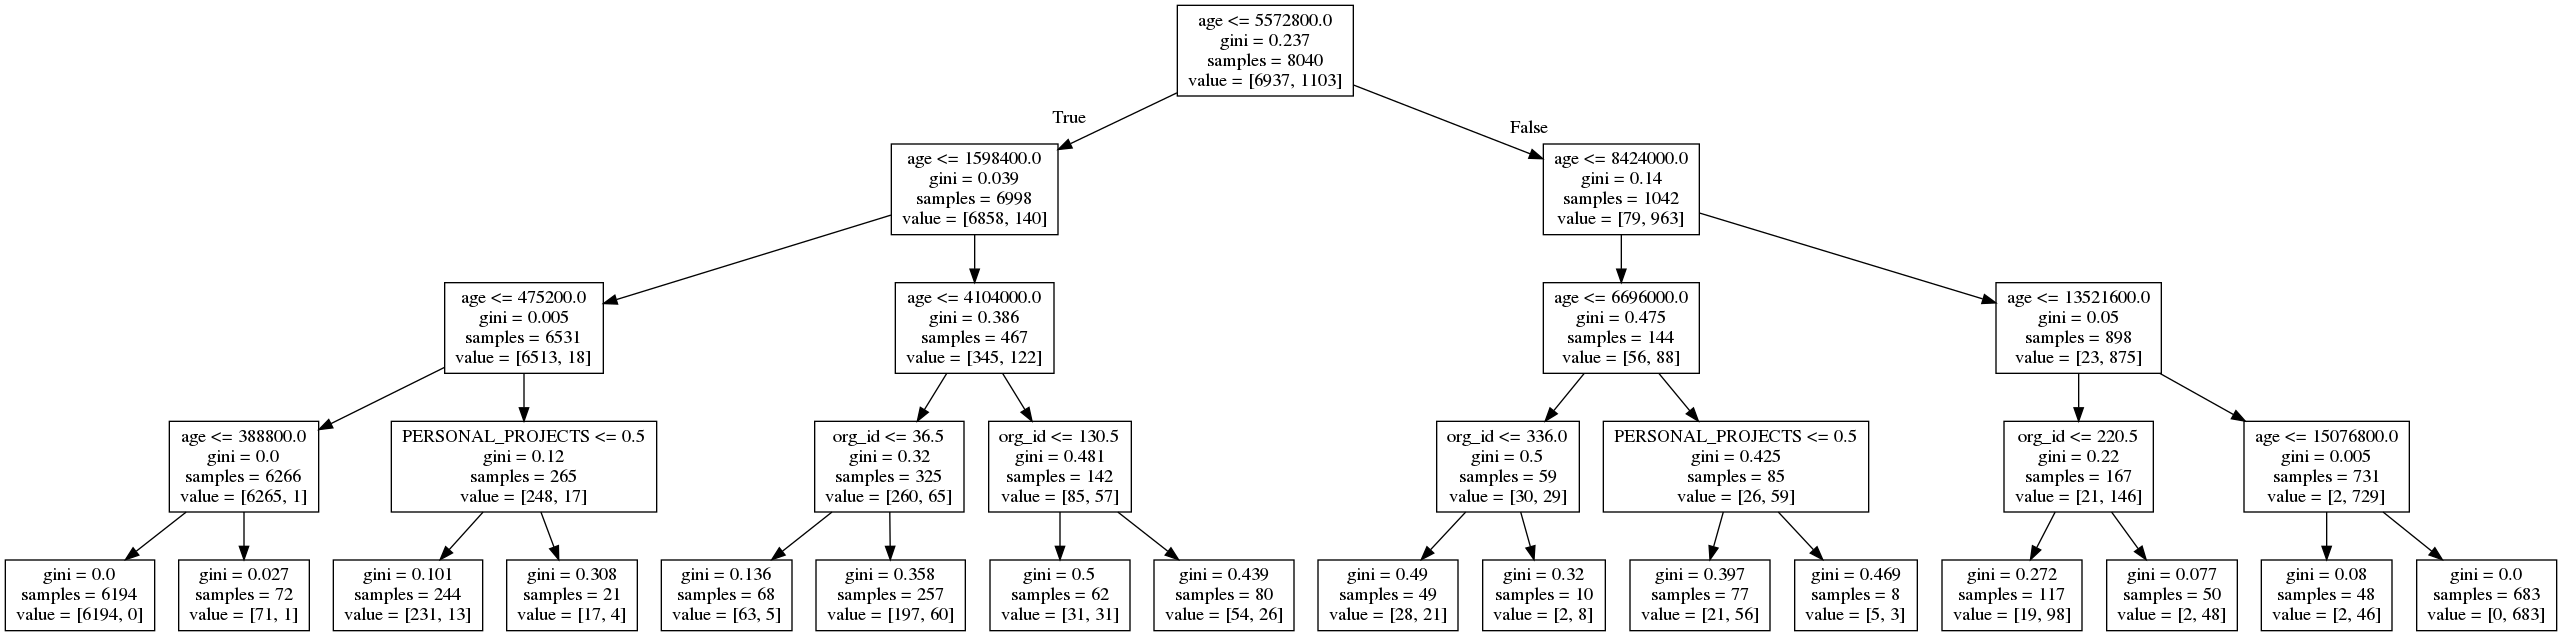

In [18]:
dot_data = StringIO()

export_graphviz(model, out_file=dot_data,  
                feature_names=list(X_train.columns))

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

It was not apparent from the feature importance graph, but the decision tree also used personal projects as a decision node. To summarize, it would seem that to predict future user adoption, great focus should be spent on the amount of time between creation and login. The next two features to focus on would be if the user is using the product for personal products, and understanding which organization a user belongs to. 